# setup

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import psycopg
from pgvector.psycopg import register_vector
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
conn = psycopg.connect(
    dbname="postgres_db",
    user="postgres_user",
    password="postgres_password",
    host="veld_embeddings_platform_run_sql_server",
    port="5432",
)
conn.autocommit = True
register_vector(conn)
cursor = conn.cursor()
cursor.execute("SELECT version();")
print(cursor.fetchone())

('PostgreSQL 17.4 on x86_64-pc-linux-gnu, compiled by gcc (Debian 10.2.1-6) 10.2.1 20210110, 64-bit',)


# load_from_db

In [24]:
l = [1, 2, 3]
print(np.array(l))
print(np.stack(l))

[1 2 3]
[1 2 3]


In [149]:
def load_from_db(lemma_list, limit=None):
    cursor.execute(
        "select lemma, sentence_id, token_index, embedding "
        "from embeddings__dbmdz__bert_base_german_cased__test "
        "where lemma = any(%s) order by sentence_id limit %s;",
        (lemma_list, limit),
    )
    rows = cursor.fetchall()
    labels = []
    embeddings = []
    for r in rows:
        labels.append(r[0] + "-" + str(r[1]) + "-" + str(r[2]))
        embeddings.append(r[3])
    labels = np.array(labels)
    embeddings = np.array(embeddings)
    print(len(embeddings))
    return (labels, embeddings)


labels_embeddings = load_from_db(["Frau", "Mann", "Haus", "Küche", "Werkstatt"])

2085


# calculate_kmeans

In [8]:
def calculate_kmeans(embeddings, n_clusters=5):
    embeddings_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    embeddings_kmeans.fit(embeddings)
    print(embeddings_kmeans.cluster_centers_.shape)
    return embeddings_kmeans


embeddings_kmeans = calculate_kmeans(labels_embeddings[1], 5)
print(embeddings_kmeans.cluster_centers_)
print(embeddings_kmeans.n_clusters)

(5, 768)
[[-0.11879632  0.88612294 -0.50703084 ...  0.3056112   0.15712492
   0.19729275]
 [ 0.0354017   0.4002436  -0.1557531  ...  0.72640127  0.07959471
   0.1849423 ]
 [-0.5125151   0.4766369   0.07869305 ...  0.43230304  0.2220129
   0.29663062]
 [-0.22991042  0.29397798  0.12151112 ... -0.3253591   0.28250423
   0.08994803]
 [-1.1767299   0.12708202  0.06755482 ...  0.29902324  0.13702673
   0.5077577 ]]
5


# calculate_tsne

In [150]:
def calculate_tsne(embeddings, n_components=2, perpexity=5):
    embeddings_tsne = TSNE(
        n_components=n_components, perplexity=perpexity, random_state=42
    ).fit_transform(embeddings)
    print(embeddings_tsne.shape)
    return embeddings_tsne


embeddings_tsne = calculate_tsne(labels_embeddings[1])

(2085, 2)


# calculate_pca

In [10]:
def calculate_pca(embeddings, n_components=2):
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings)
    print(embeddings_pca.shape)
    return embeddings_pca


embeddings_pca = calculate_pca(labels_embeddings[1])

(812, 2)


# show_plot

In [ ]:
# - One of the following named colorscales:
#       ['aggrnyl', 'agsunset', 'algae', 'amp', 'armyrose', 'balance',
#        'blackbody', 'bluered', 'blues', 'blugrn', 'bluyl', 'brbg',
#        'brwnyl', 'bugn', 'bupu', 'burg', 'burgyl', 'cividis', 'curl',
#        'darkmint', 'deep', 'delta', 'dense', 'earth', 'edge', 'electric',
#        'emrld', 'fall', 'geyser', 'gnbu', 'gray', 'greens', 'greys',
#        'haline', 'hot', 'hsv', 'ice', 'icefire', 'inferno', 'jet',
#        'magenta', 'magma', 'matter', 'mint', 'mrybm', 'mygbm', 'oranges',
#        'orrd', 'oryel', 'oxy', 'peach', 'phase', 'picnic', 'pinkyl',
#        'piyg', 'plasma', 'plotly3', 'portland', 'prgn', 'pubu', 'pubugn',
#        'puor', 'purd', 'purp', 'purples', 'purpor', 'rainbow', 'rdbu',
#        'rdgy', 'rdpu', 'rdylbu', 'rdylgn', 'redor', 'reds', 'solar',
#        'spectral', 'speed', 'sunset', 'sunsetdark', 'teal', 'tealgrn',
#        'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',
#        'turbo', 'twilight', 'viridis', 'ylgn', 'ylgnbu', 'ylorbr',
#        'ylorrd'].

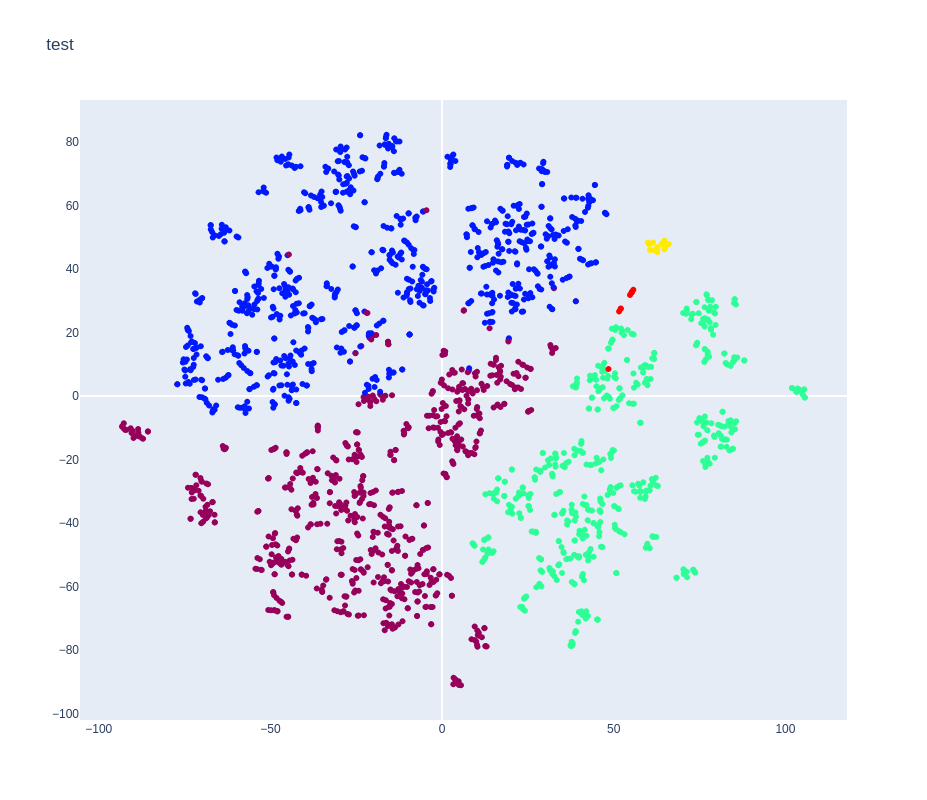

In [151]:
def show_plot(labels, embeddings, title=None, show_labels=False, color_by="lemma"):
    # kmeans = KMeans(n_clusters=4, random_state=0).fit(data_test)
    # labels = kmeans.labels_
    # centroids = kmeans.cluster_centers_

    if color_by:
        if color_by == "lemma":
            color_id_list = []
            color_id_dict = {}
            color_id_current = 0
            for l in labels:
                lemma = l.split("-")[0]
                color_id = color_id_dict.get(lemma)
                if color_id is None:
                    color_id = color_id_current
                    color_id_dict[lemma] = color_id
                    color_id_current += 1
                color_id_list.append(color_id)
        elif color_by == "kmeans":
            raise Exception()
        else:
            raise Exception('arg `color_by` must be either `"lemma"`, `"kmeans"`, or `None`')
    else:
        color_id_list = [0 for _ in embeddings]
        
    fig = go.Figure(
        data=go.Scatter(
            x=embeddings[:, 0],
            y=embeddings[:, 1],
            mode="markers",
            customdata=labels[:, np.newaxis],
            marker=dict(
                color=color_id_list,
                colorscale="rainbow",
            ),
            hovertemplate="x: %{x}<br>y: %{y}, label: %{customdata[0]}<extra></extra>",
            showlegend=False,
        ),
        layout=go.Layout(
            title=title,
            width=800,
            height=800,
            xaxis=dict(showgrid=False),
            yaxis=dict(showgrid=False),
        ),
    )
    # for i, (cx, cy) in enumerate(centroids):
    #     fig.add_scatter(
    #         x=[cx],
    #         y=[cy],
    #         mode="markers+text",
    #         marker=dict(
    #             color="red",
    #             size=20,
    #             symbol="x",
    #         ),
    #         text=[f"Centroid {i}"],
    #         textposition="top center",
    #         showlegend=False,
    #         hovertemplate="x: %{x}<br>y: %{y}<extra></extra>",
    #     )
    fig.show()


show_plot(labels=labels_embeddings[0], embeddings=embeddings_tsne, title="test", show_labels=False)

# various experiments

## kmeans

### kmeans from scratch

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(42)

In [26]:
k = 4

In [27]:
data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

(300, 2)


In [28]:
def init_centroids(data, k, debug_print=False):
    indices = np.random.choice(data.shape[0], size=k, replace=False)
    centroids = data[indices]
    if debug_print:
        print("-- init_centroids --")
        print(centroids.shape)
        print(centroids)
    return centroids


centroids_test = init_centroids(data_test, k, True)

-- init_centroids --
(4, 2)
[[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]


In [29]:
def assign_centroid(data, centroids, debug_print=False):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    data_centroids_indices = np.argmin(distances, axis=1)
    if debug_print:
        print("-- assign_centroid --")
        print("distances.shape:", distances.shape)
        print("distances[0]:", distances[0])
        print("data[0]:", data[0])
        print("centroids:", centroids)
        print(
            "np.linalg.norm(data[0] - centroids, axis=1):",
            np.linalg.norm(data[0] - centroids, axis=1),
        )
        print("data_centroids_indices[0]:", data_centroids_indices[0])
    return data_centroids_indices


data_centroids_indices_test = assign_centroid(data_test, centroids_test, True)

-- assign_centroid --
distances.shape: (300, 4)
distances[0]: [2.4430004  1.76215017 2.82213359 6.3526692 ]
data[0]: [0.2276515  2.75570724]
centroids: [[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]
np.linalg.norm(data[0] - centroids, axis=1): [2.4430004  1.76215017 2.82213359 6.3526692 ]
data_centroids_indices[0]: 1


In [30]:
def update_centroids(data, centroids, data_centroids_indices, debug_print=False):
    centroids_new = np.array([data[data_centroids_indices == i].mean(axis=0) for i in range(k)])
    if debug_print:
        print("-- update_centroids --")
        print("centroids:", centroids)
        print("centroids_new:", centroids_new)
    return centroids_new


centroids_new_test = update_centroids(data_test, centroids_test, data_centroids_indices_test, True)

-- update_centroids --
centroids: [[-1.947065    1.64266676]
 [ 1.75426266  3.63583881]
 [-0.2778782   5.53219382]
 [-0.44252153  9.07292768]]
centroids_new: [[-1.36677696  2.26219709]
 [ 1.73282234  2.34291985]
 [-0.58894072  5.53489617]
 [-1.43923493  8.12521409]]


In [31]:
def have_centroids_converged(centroids, centroids_new, threshold, debug_print=False):
    distances = np.linalg.norm(centroids - centroids_new, axis=1)
    have_centroids_converged = np.all(distances < threshold)
    if debug_print:
        print("-- have_centroids_converged --")
        print("distance:", distances)
        print("have_centroids_converged:", have_centroids_converged)
    return have_centroids_converged


centroids_converged_test = have_centroids_converged(centroids_test, centroids_new_test, True)

In [32]:
def kmeans_main(data, k, threshold=1e-1, debug_print=False):
    if debug_print:
        print("-- kmeans_main: start --")
    centroids = init_centroids(data, k, debug_print)
    centroids_converged = False
    while not centroids_converged:
        data_centroids_indices = assign_centroid(data, centroids, debug_print)
        centroids_new = update_centroids(data, centroids, data_centroids_indices, debug_print)
        centroids_converged = have_centroids_converged(
            centroids, centroids_new, threshold, debug_print
        )
        centroids = centroids_new
    if debug_print:
        print("-- kmeans_main: end --")
        print(centroids, data_centroids_indices)
    return centroids, data_centroids_indices


centroids, data_centroids_indices = kmeans_main(
    data=data_test, k=4, threshold=1e-4, debug_print=False
)

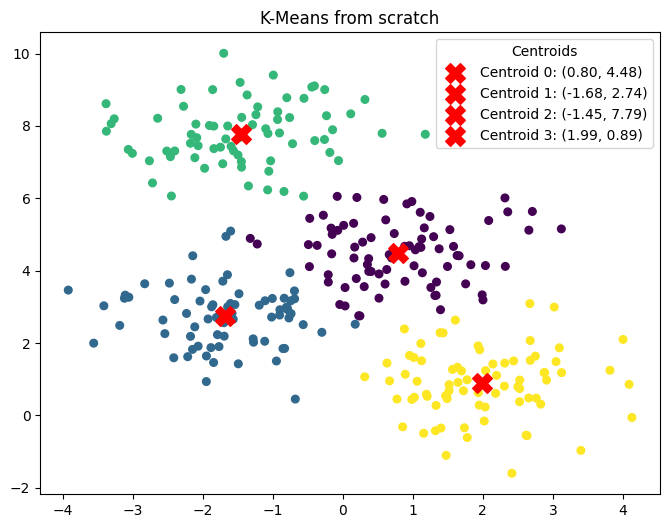

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=data_centroids_indices, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("K-Means from scratch")
plt.show()

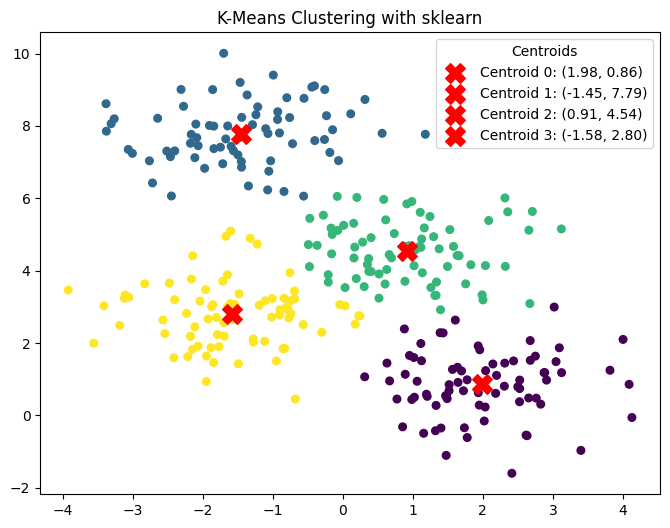

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_test)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=labels, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("K-Means Clustering with sklearn")
plt.show()

### kmeans visualizations

(300, 2)


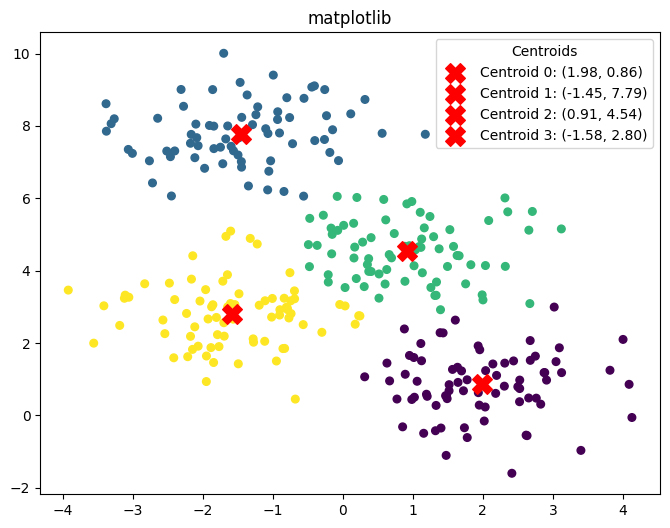

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_test)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
plt.scatter(data_test[:, 0], data_test[:, 1], c=labels, cmap="viridis", s=30)
handles = []
labels_for_legend = []
for i, (x, y) in enumerate(centroids):
    handle = plt.scatter(x, y, color="red", s=200, marker="X")
    handles.append(handle)
    labels_for_legend.append(f"Centroid {i}: ({x:.2f}, {y:.2f})")
plt.legend(handles, labels_for_legend, title="Centroids", loc="best")
plt.title("matplotlib")
plt.show()

(300, 2)


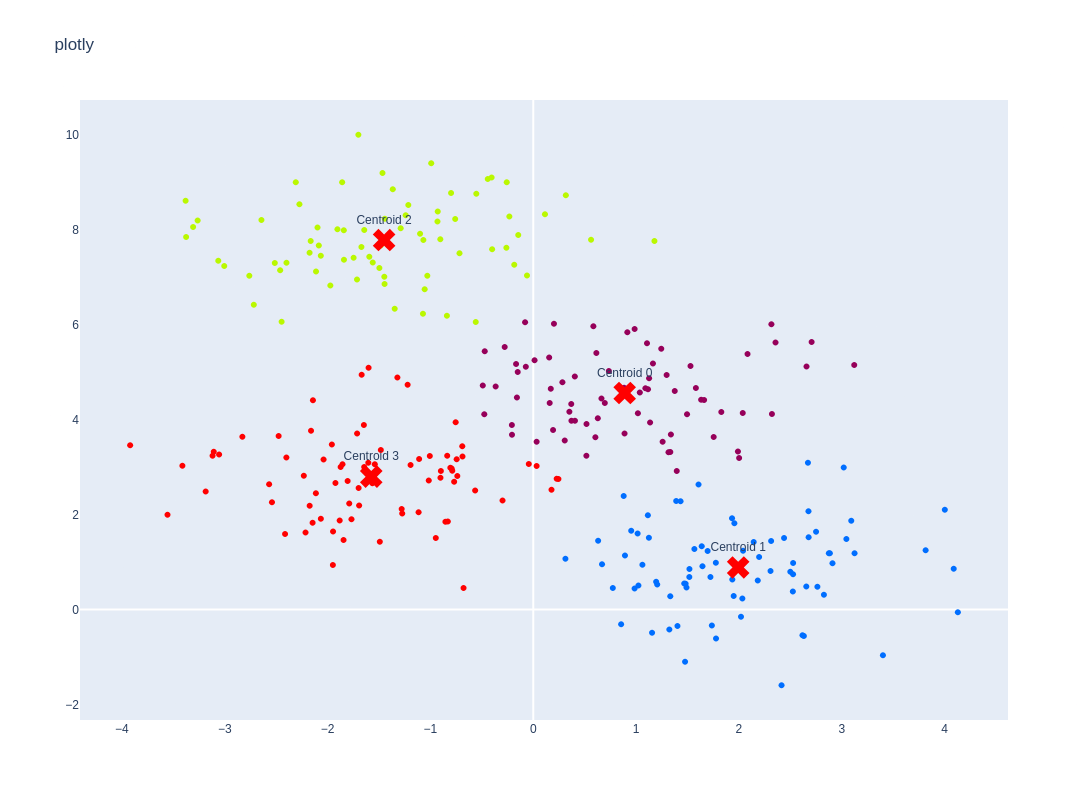

In [4]:
import numpy as np
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

data_test, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=0)
print(data_test.shape)

kmeans = KMeans(n_clusters=4, random_state=0).fit(data_test)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig = go.Figure(
    data=go.Scatter(
        x=data_test[:, 0],
        y=data_test[:, 1],
        mode="markers",
        marker=dict(
            color=labels,
            colorscale="rainbow",
        ),
        hovertemplate="x: %{x}<br>y: %{y}<extra></extra>",
        showlegend=False,
    ),
    layout=go.Layout(
        title="plotly",
        width=800,
        height=800,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
    ),
)
for i, (cx, cy) in enumerate(centroids):
    fig.add_scatter(
        x=[cx],
        y=[cy],
        mode="markers+text",
        marker=dict(
            color="red",
            size=20,
            symbol="x",
        ),
        text=[f"Centroid {i}"],
        textposition="top center",
        showlegend=False,
        hovertemplate="x: %{x}<br>y: %{y}<extra></extra>",
    )

fig.show()

### elbow method

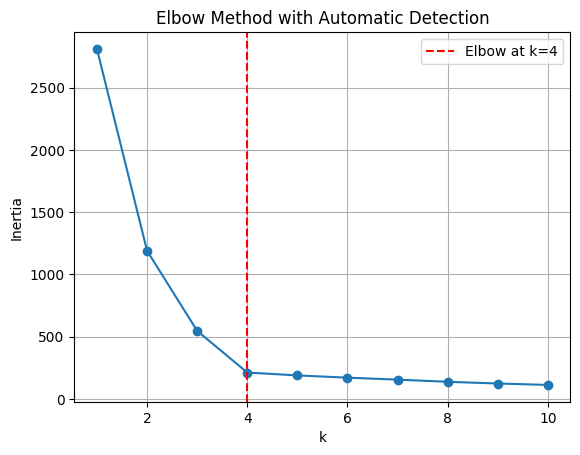

Optimal number of clusters (Elbow): 4


In [20]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Sample data
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=0)

inertia = []
K = range(1, 11)

for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=0)
    model.fit(X)
    inertia.append(model.inertia_)

# Find elbow point
knee = KneeLocator(K, inertia, curve="convex", direction="decreasing")

# Plot
plt.plot(K, inertia, marker="o")
plt.axvline(x=knee.knee, color="r", linestyle="--", label=f"Elbow at k={knee.knee}")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method with Automatic Detection")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of clusters (Elbow): {knee.knee}")

## snippets to be removed

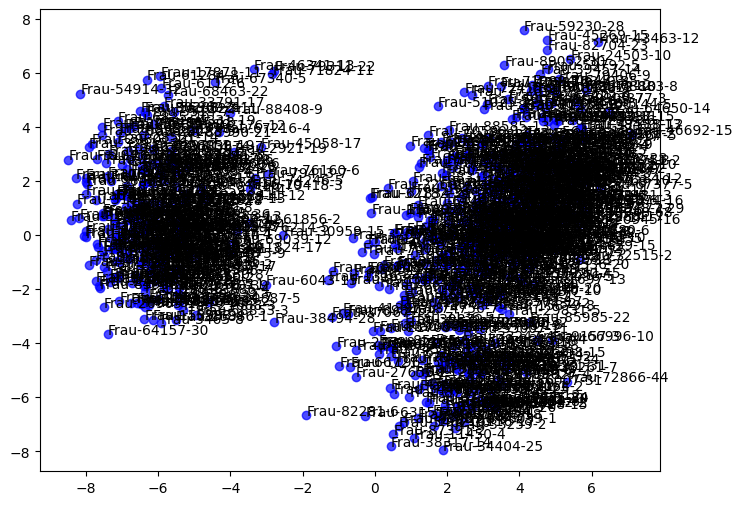

In [21]:
def show_plot_pca(labels_embeddings, title=None):
    labels = labels_embeddings[0]
    embeddings = labels_embeddings[1]
    pca = PCA(n_components=2)
    embeddings_reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], color="blue", alpha=0.7)
    for r, l in zip(embeddings_reduced, labels):
        plt.text(r[0], r[1], l)
    plt.title(title)
    plt.show()


show_plot_pca(labels_embeddings)

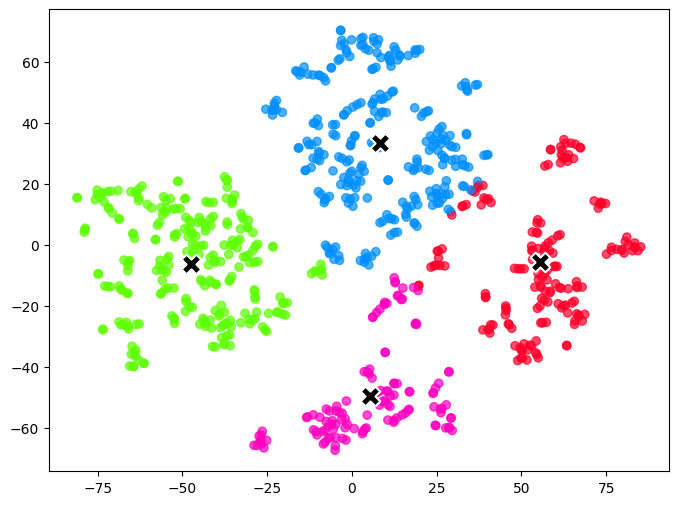

[[ 55.570133   -5.6113324]
 [-47.41258    -6.32986  ]
 [  8.146011   33.497185 ]
 [  5.286042  -49.312397 ]]
[1 1 1 2 3 2 3 1 0 1 2 3 1 3 3 1 1 1 1 1 1 1 1 0 0 2 1 1 3 3 0 3 3 1 1 3 2
 1 2 2 2 3 2 1 2 0 2 1 2 2 3 3 3 2 1 1 1 2 3 0 0 0 2 0 3 3 3 3 2 0 0 0 0 0
 2 0 3 2 2 3 1 0 3 1 0 3 1 3 1 1 2 3 2 1 1 1 1 0 0 1 1 2 3 1 1 2 1 0 1 3 0
 0 1 2 1 1 1 1 1 0 0 3 3 3 3 2 3 2 2 0 2 2 1 2 3 2 0 0 1 1 1 2 3 3 3 3 3 0
 0 1 2 1 0 0 2 2 0 0 2 0 2 2 3 3 3 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 1 1 1 1
 1 1 1 3 3 3 1 2 0 1 1 1 2 3 0 1 2 2 1 1 1 1 0 1 1 1 1 1 1 1 1 2 0 2 3 3 3
 1 2 1 1 0 1 1 1 1 1 1 1 2 1 0 3 1 1 1 1 1 1 1 0 2 3 1 0 1 0 1 2 1 1 1 3 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 3 1 2 1 1 2 0 0 0 3 3 3 0 0 1 2 1 1 3 3 3
 3 2 0 0 0 0 0 2 0 0 2 0 2 0 1 1 2 2 0 2 0 0 0 3 3 1 1 1 3 1 1 2 2 2 2 2 3
 0 0 2 2 2 2 2 2 2 0 0 3 1 2 1 1 1 2 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 3 2 2 2 0 0 2 2 0 0 1 2 3 3 2 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 2 0 0 0 0 0
 1 1 2 1 1 2 1 1 3 2 0 2 3 3 0 2 2 2 0 2 0 0 0 0 0 2 0 0 0 0 2 3 2

In [22]:
def get_kmeans(labels_embeddings, title=None):
    labels = labels_embeddings[0]
    embeddings = labels_embeddings[1]
    # print(kmeans.cluster_centers_)
    # print(kmeans.labels_)
    reduced = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings)

    # pca = PCA(n_components=5)
    # reduced = pca.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(reduced)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans.labels_, cmap="gist_rainbow", alpha=0.7)

    # tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    # embeddings_reduced = tsne.fit_transform(embeddings)
    # plt.figure(figsize=(8, 6))
    # plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c=kmeans.labels_, alpha=0.7)

    # for i, label in enumerate(labels):
    #    plt.text(reduced[i, 0], reduced[i, 1], label)

    # reduced_centers = pca.fit_transform(kmeans.cluster_centers_)
    reduced_centers = kmeans.cluster_centers_
    plt.scatter(
        reduced_centers[:, 0],
        reduced_centers[:, 1],
        marker="X",
        s=200,
        c="black",
        edgecolor="white",
        linewidth=1.5,
        label="Centroids",
    )

    plt.title(title)
    plt.show()
    return kmeans


kmeans = get_kmeans(labels_embeddings)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

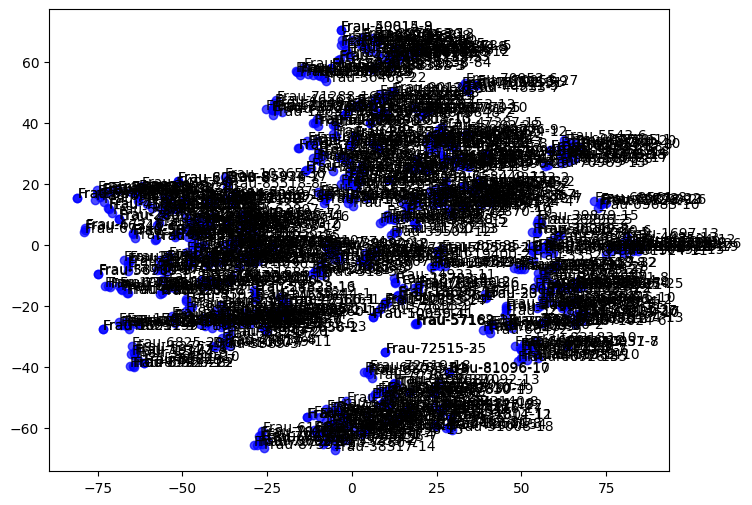

In [23]:
def show_plot_tsne(labels_embeddings, title=None):
    labels = labels_embeddings[0]
    embeddings = labels_embeddings[1]
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    embeddings_reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_reduced[:, 0], embeddings_reduced[:, 1], c="blue", alpha=0.7)
    for i, label in enumerate(labels):
        plt.text(
            embeddings_reduced[i, 0],
            embeddings_reduced[i, 1],
            label,
        )
    plt.title(title)
    plt.show()


show_plot_tsne(labels_embeddings)